<a href="https://colab.research.google.com/github/DeepFluxion/IBMEC_Aprendizado_Reforco/blob/main/Aula_13/Aula_13_Monte_Carlo_ES_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introdução e objetivo

O método **Monte Carlo Exploring-Starts (ES) Control** é uma técnica para **aprender uma política ótima** quando
temos a capacidade de iniciar episódios a partir de pares arbitrários de `(estado, ação)` — os chamados *exploring starts*.
A versão ES do Monte Carlo garante que cada par $(s,a)$ possa ser *explorado* porque os episódios começam aleatoriamente
com um estado e uma ação iniciais amostrados do espaço. Isso permite convergência para uma política ótima sob hipóteses padrão.

Referência: Sutton, R. S. & Barto, A. G. (2018). *Reinforcement Learning: An Introduction*, Capítulo 5.3 (Monte Carlo ES Control).

### 1.1 Componentes e definições

- **Recompensa** $R_t$: sinal numérico recebido após executar a ação no ambiente (ex.: +1 vitória, 0 empate, -1 derrota).
- **Retorno** $G_t$: soma descontada das recompensas a partir do tempo \(t\):
$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots
$$
  Calculamos recursivamente: \(G_t = R_{t+1} + \gamma G_{t+1}\).

- **Fator de desconto** $\gamma \in [0,1]$: reduz o peso de recompensas futuras. $\gamma$ próximo de 1 valoriza recompensas futuras; próximo de 0 prioriza recompensas imediatas.

- **Função ação-valor** $Q_\pi(s,a)$:
$$
Q_\pi(s,a) = \mathbb{E}_\pi[G_t \mid S_t = s, A_t = a]
$$
  Representa a qualidade esperada de tomar ação \(a\) em \(s\) e seguir a política $\pi$ depois.

- **Política** $\pi$: mapeamento de estados para ações (determinística ou estocástica). No ES usamos o fato de podermos iniciar em $(s,a)$ qualquer para explorar o espaço.

- **Exploring Starts (ES)**: habilidade de iniciar episódios a partir de *amostras aleatórias de* $(S_0, A_0)$. Isso substitui a necessidade de políticas exploratórias (como ε-greedy) para garantir cobertura do espaço de pares $(s,a)$ em teoria.

### 1.2 Pseudocódigo (cap. 5.3, versão concisa)

```
Inicializar Q(s,a) arbitrariamente (por ex. 0)
Inicializar Returns(s,a) como lista vazia (ou soma+contador para eficiência)
Inicializar política π arbitrária (pode ser aleatória)
Para cada episódio:
    Amostrar (S0, A0) uniformemente do conjunto de pares válidos (exploring starts)
    Gerar um episódio começando em (S0, A0) seguindo π (A0 fixo no t=0)
    G ← 0
    Para t = T-1 até 0:
        G ← γ * G + R_{t+1}
        Se (S_t, A_t) primeira visita no episódio:
            Adicionar G a Returns(S_t, A_t)
            Q(S_t, A_t) ← média(Returns(S_t, A_t))
            π(S_t) ← argmax_a Q(S_t, a)
```
**Observação:** em implementações práticas, usar soma dos retornos + contadores é mais eficiente em memória do que manter listas de retornos.

In [ ]:
# ! pip install gymnasium

In [ ]:
# Monte Carlo Exploring-Starts (ES) Control - Versão Corrigida
from __future__ import annotations
import numpy as np
from collections import defaultdict
from typing import Any, Callable, Dict, List, Tuple
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Tipos
State = Any
Action = int
Policy = Dict[State, Action]

In [ ]:
class BlackjackES:
    """
    Wrapper para Blackjack com suporte a Exploring Starts.
    Versão corrigida compatível com Gym/Gymnasium.
    """
    def __init__(self, gym_env=None):
        try:
            import gymnasium as gym
            self._env = gym_env or gym.make('Blackjack-v1')
        except ImportError:
            import gym
            self._env = gym_env or gym.make('Blackjack-v1')
        self.nb_actions = 2

    def sample_state_action(self) -> Tuple[Tuple[int,int,bool], int]:
        """Amostra um par (estado, ação) válido."""
        player_sum = np.random.randint(12, 22)      # 12..21
        dealer_shows = np.random.randint(1, 11)     # 1..10
        has_ace = bool(np.random.randint(0, 2))     # True/False
        state = (player_sum, dealer_shows, has_ace)
        action = int(np.random.randint(0, 2))
        return state, action

    def _sum_hand(self, hand: List[int]) -> int:
        """Calcula a soma de uma mão (implementação própria)."""
        return sum(hand)

    def _usable_ace(self, hand: List[int]) -> bool:
        """Verifica se há um ás utilizável (implementação própria)."""
        return 1 in hand and sum(hand) + 10 <= 21

    def reset_es(self, init_state: Tuple[int,int,bool]):
        """
        Força o ambiente a iniciar em init_state (Exploring Starts).
        Versão corrigida para compatibilidade Gym/Gymnasium.
        """
        base_env = self._env.unwrapped
        player_sum, dealer_shows, has_ace = init_state

        self._env.reset()

        # Configurar dealer
        dealer_hides = np.random.choice([1,2,3,4,5,6,7,8,9,10,10,10,10])
        base_env.dealer = [dealer_shows, dealer_hides]

        # Configurar player
        if has_ace:
            base_env.player = [player_sum - 11, 1]
        else:
            if player_sum == 21:
                base_env.player = [10, 9, 2]
            else:
                base_env.player = [player_sum - 10, 10]

        # Reconstruir observação usando métodos próprios
        obs = (
            self._sum_hand(base_env.player) +
            (10 if self._usable_ace(base_env.player) else 0),
            base_env.dealer[0],
            self._usable_ace(base_env.player)
        )
        return obs

    def step(self, action: int):
        """Executa uma ação no ambiente."""
        return self._env.step(action)

In [ ]:
def generate_episode_ES(env_ES: BlackjackES, pi: Policy,
                        S0: Tuple[int,int,bool], A0: int):
    """
    Gera um episódio completo começando em (S0, A0).

    Retorna:
        trajectory: lista de (state, reward, done, action)
        T: índice do estado terminal
    """
    trajectory = []
    done = True
    At = None

    while True:
        if done:
            St = env_ES.reset_es(S0)
            Rt = None
            done = False
            At = A0
        else:
            result = env_ES.step(At)
            # Compatível com gym e gymnasium
            if len(result) == 5:  # gymnasium
                St, Rt, terminated, truncated, _ = result
                done = terminated or truncated
            else:  # gym
                St, Rt, done, _ = result
            At = pi.get(St, 0)

        trajectory.append((St, Rt, done, At))
        if done:
            break

    return trajectory, len(trajectory) - 1

In [ ]:
def monte_carlo_ES_control(env_ES: BlackjackES, episodes: int = 100000,
                          gamma: float = 1.0, verbose: bool = False):
    """
    Implementação do algoritmo Monte Carlo ES Control (primeira visita).

    Args:
        env_ES: instância de BlackjackES
        episodes: número de episódios
        gamma: fator de desconto
        verbose: se True, mostra progresso

    Retorna:
        Q: dicionário Q[(state, action)] -> valor
        pi: política derivada (determinística)
    """
    Q = defaultdict(float)
    Returns_sum = defaultdict(float)
    Counts = defaultdict(int)
    pi: Policy = defaultdict(int)

    for ep in range(episodes):
        if verbose and (ep + 1) % 10000 == 0:
            print(f"Episódio {ep + 1}/{episodes}")

        # Exploring start
        S0, A0 = env_ES.sample_state_action()

        # Gerar episódio
        traj, T = generate_episode_ES(env_ES, pi, S0, A0)

        # Calcular retornos e atualizar Q (primeira visita)
        G = 0.0
        visited_sa = set()

        for t in range(T - 1, -1, -1):
            St, _, _, At = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if (t + 1) < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1

            sa = (St, At)
            if sa not in visited_sa:
                visited_sa.add(sa)
                Counts[sa] += 1
                Returns_sum[sa] += G
                Q[sa] = Returns_sum[sa] / Counts[sa]

                # Melhorar política (argmax com tie-breaking aleatório)
                q_vals = [Q.get((St, a), 0.0) for a in range(env_ES.nb_actions)]
                max_q = max(q_vals)
                choices = [i for i, q in enumerate(q_vals) if q == max_q]
                pi[St] = int(np.random.choice(choices))

    return Q, pi

In [ ]:
def monte_carlo_ES_control_ext(env_ES: BlackjackES, episodes: int = 100000, gamma: float = 1.0, callback: Callable = None, resume_dicts=None, focus_S0=None):
    """
    Versão estendida com:
      - Returns_sum e Counts (soma+contador) para cada (s,a)
      - opção de callback(ep, Q) para registrar histórico/trace
      - resume_dicts para retomar treinamento
      - focus_S0 para forçar sempre o mesmo S0 (útil para debugging)
    Retorna Q, pi, (pi, Counts, Returns_sum, Q) para possível resume.
    """
    if resume_dicts is None:
        pi = defaultdict(int)
        C = defaultdict(int)
        Returns = defaultdict(float)
        Q = defaultdict(float)
    else:
        pi, C, Returns, Q = resume_dicts

    trace_count = 0
    for e in range(episodes):
        S0, A0 = env_ES.sample_state_action()
        if focus_S0 is not None:
            S0 = focus_S0
        traj, T = generate_episode_ES(env_ES, pi, S0, A0)
        G = 0.0
        for t in range(T-1, -1, -1):
            St, _, _, At = traj[t]
            _, Rt_1, _, _ = traj[t+1] if (t+1) < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1
            # Every-visit update: soma e contador
            C[(St, At)] += 1
            Returns[(St, At)] += G
            Q[(St, At)] = Returns[(St, At)] / C[(St, At)]
            # melhoria de política -> chosen argmax
            q_vals = [Q.get((St, a), 0.0) for a in range(env_ES.nb_actions)]
            choices = [i for i, q in enumerate(q_vals) if q == max(q_vals)]
            pi[St] = int(np.random.choice(choices))

        if callback is not None:
            callback(e, Q)
        trace_count += 1
    return Q, pi, (pi, C, Returns, Q)

In [ ]:
# Funções de visualização

def q_to_v_approx(Q: Dict[Tuple, float], n_actions: int = 2):
    """Calcula V(s) ≈ max_a Q(s,a)"""
    state_max = {}
    for (s, a), qv in Q.items():
        state_max[s] = max(state_max.get(s, -np.inf), qv)
    return state_max


In [ ]:
def value_dict_to_array(V_dict, has_ace: bool):
    """Converte V(s) dict para matriz 10x10"""
    Vd = defaultdict(float, V_dict)
    arr = np.zeros((10, 10))
    for ps in range(12, 22):
        for dc in range(1, 11):
            arr[ps - 12, dc - 1] = Vd.get((ps, dc, has_ace), 0.0)
    return arr

In [ ]:
def plot_q_value_heatmap(Q, title_prefix: str = '', state_values: bool = False,
                         fmt: str = '.2f', n_actions: int = 2):
    """Plota heatmaps de V(s) aproximado a partir de Q."""
    V_approx = q_to_v_approx(Q, n_actions)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, ace in zip(axes, [True, False]):
        data = value_dict_to_array(V_approx, ace)
        im = ax.imshow(data, origin='lower', extent=[0.5, 10.5, 11.5, 21.5],
                      aspect='auto', cmap='viridis')
        ax.set_title(f"{title_prefix}V(s) - usable_ace={ace}")
        ax.set_xlabel('Carta visível do dealer')
        ax.set_ylabel('Soma do jogador')
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))

        if state_values:
            nrows, ncols = data.shape
            for i in range(nrows):
                for j in range(ncols):
                    color = 'white' if data[i, j] < 0 else 'black'
                    ax.text(j + 1, i + 12, format(data[i, j], fmt),
                           ha='center', va='center', fontsize=7, color=color)

        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_policy_heatmap(pi, title: str = 'Política (greedy)', state_values: bool = False):
    """Plota mapa da política greedy (0=stick, 1=hit)."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, ace in zip(axes, [True, False]):
        arr = np.zeros((10, 10))
        for ps in range(12, 22):
            for dc in range(1, 11):
                val = pi.get((ps, dc, ace), 0)
                arr[ps - 12, dc - 1] = val

        im = ax.imshow(arr, origin='lower', extent=[0.5, 10.5, 11.5, 21.5],
                      aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
        ax.set_title(f"{title} - usable_ace={ace}")
        ax.set_xlabel('Carta visível do dealer')
        ax.set_ylabel('Soma do jogador')
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))

        if state_values:
            nrows, ncols = arr.shape
            for i in range(nrows):
                for j in range(ncols):
                    action_text = 'HIT' if arr[i, j] == 1 else 'STICK'
                    ax.text(j + 1, i + 12, action_text, ha='center',
                           va='center', fontsize=6, color='black', weight='bold')

        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['STICK', 'HIT'])

    plt.tight_layout()
    plt.show()

In [ ]:
def value_dict_to_dataframe(V_dict, has_ace: bool) -> pd.DataFrame:
    """Converte V(s) dict em DataFrame pandas"""
    index = list(range(12, 22))
    cols = list(range(1, 11))
    data = []
    for ps in index:
        row = []
        for dc in cols:
            row.append(V_dict.get((ps, dc, has_ace), np.nan))
        data.append(row)
    df = pd.DataFrame(data, index=index, columns=cols)
    df.index.name = 'player_sum'
    df.columns.name = 'dealer_card'
    return df

In [ ]:
# ============================================================================
# FUNÇÕES DE TRACE E ANÁLISE DE CONVERGÊNCIA
# ============================================================================

def convert_to_sum(Q, nb_actions=2):
    """
    Converte dicionário Q para array 4D.
    Dimensões: [player_sum, dealer_card, has_ace, action]
    """
    res = np.zeros([10, 10, 2, nb_actions])

    for ps in range(12, 22):
        for dc in range(1, 11):
            for ha in [0, 1]:
                for act in range(nb_actions):
                    key = ((ps, dc, bool(ha)), act)
                    res[ps - 12, dc - 1, ha, act] = Q.get(key, 0.0)

    return res

In [ ]:
def plot_Q_trace(trace, has_ace=0, start_at=None, full_scale=False,
                 figsize=(16, 12), save_path=None):
    """
    Plota a evolução dos Q-valores ao longo do treinamento.

    Args:
        trace: lista de arrays capturados durante treinamento
        has_ace: 0 ou 1 (sem/com ás utilizável)
        start_at: índice inicial (None=início, negativo=relativo ao fim)
        full_scale: se True, mesma escala Y para todos
        save_path: caminho para salvar figura (opcional)
    """
    if len(trace) == 0:
        print("Erro: trace está vazio!")
        return

    # Processar start_at
    if start_at is None:
        start_idx = 0
    elif start_at < 0:
        start_idx = max(0, len(trace) + start_at)
    else:
        start_idx = min(start_at, len(trace) - 1)

    trace_subset = trace[start_idx:]
    n_samples = len(trace_subset)

    if n_samples == 0:
        print("Erro: nenhum dado no intervalo!")
        return

    # Extrair dados
    trace_array = np.array(trace_subset)[:, :, :, has_ace, :]

    # Criar figura
    fig, axes = plt.subplots(10, 10, figsize=figsize)
    fig.suptitle(f'Q trace - {"with" if has_ace else "no"} ace - '
                 f'start at: {start_at} - full scale: {full_scale}',
                 fontsize=14, y=0.995)

    # Escala global
    if full_scale:
        global_min = trace_array.min()
        global_max = trace_array.max()

    # Plotar cada estado
    for row in range(10):
        for col in range(10):
            ax = axes[9 - row, col]

            # Q-valores para este estado
            q_stick = trace_array[:, row, col, 0]  # STICK
            q_hit = trace_array[:, row, col, 1]    # HIT

            # Plotar
            x = np.arange(n_samples)
            ax.plot(x, q_stick, 'b-', linewidth=1, alpha=0.7)
            ax.plot(x, q_hit, 'r-', linewidth=1, alpha=0.7)

            if full_scale:
                ax.set_ylim([global_min, global_max])

            ax.set_xticks([])
            ax.set_yticks([])
            ax.grid(True, alpha=0.2, linewidth=0.5)

            for spine in ax.spines.values():
                spine.set_linewidth(0.5)

    # Labels
    for row in range(10):
        player_sum = 21 - row
        axes[row, 0].set_ylabel(str(player_sum), fontsize=8,
                                rotation=0, ha='right', va='center')

    for col in range(10):
        dealer_card = col + 1
        axes[9, col].set_xlabel(str(dealer_card), fontsize=8)

    # Legenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='b', lw=2, label='Stick'),
        Line2D([0], [0], color='r', lw=2, label='Hit')
    ]
    fig.legend(handles=legend_elements, loc='upper right',
              bbox_to_anchor=(0.99, 0.99), fontsize=10)

    plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figura salva em: {save_path}")

    plt.show()

In [ ]:
def setup_trace_callback():
    """
    Cria trace e callback para uso com monte_carlo_ES_control_ext.

    Returns:
        trace: lista para snapshots
        callback: função para passar ao algoritmo
    """
    trace = []

    def callback(ep, Q):
        if ep % 1000 == 0:
            trace.append(convert_to_sum(Q))

    return trace, callback

## Execução / Exemplo de uso

A célula abaixo é um exemplo que você pode executar interativamente.

Treinando os episódios...

✓ Treinamento concluído!
✓ Snapshots capturados: 100
✓ Estados visitados: 200


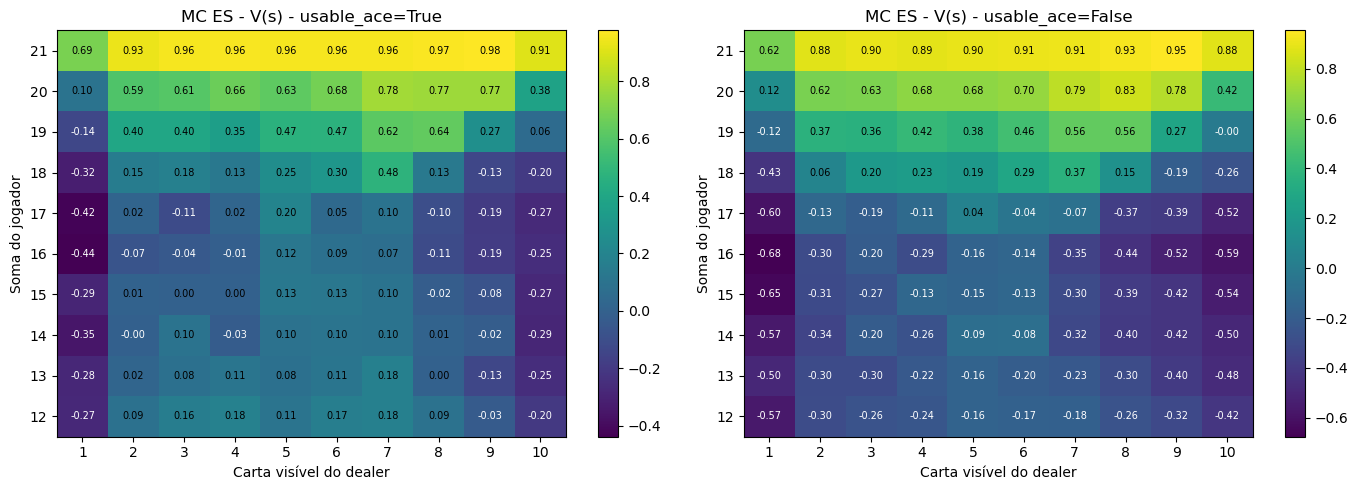

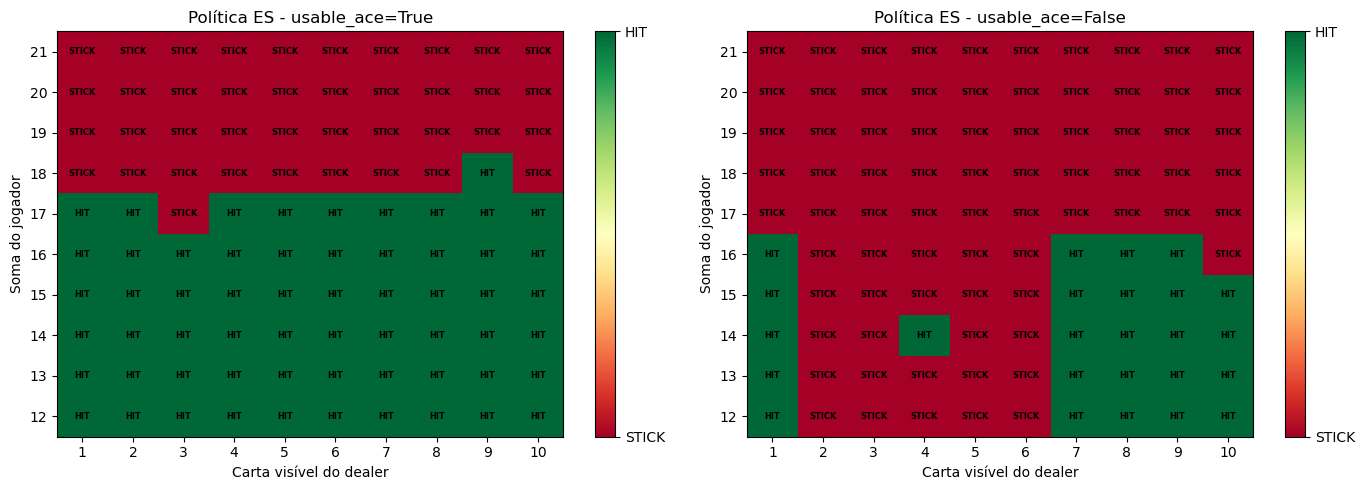


Plotando evolução dos Q-valores...


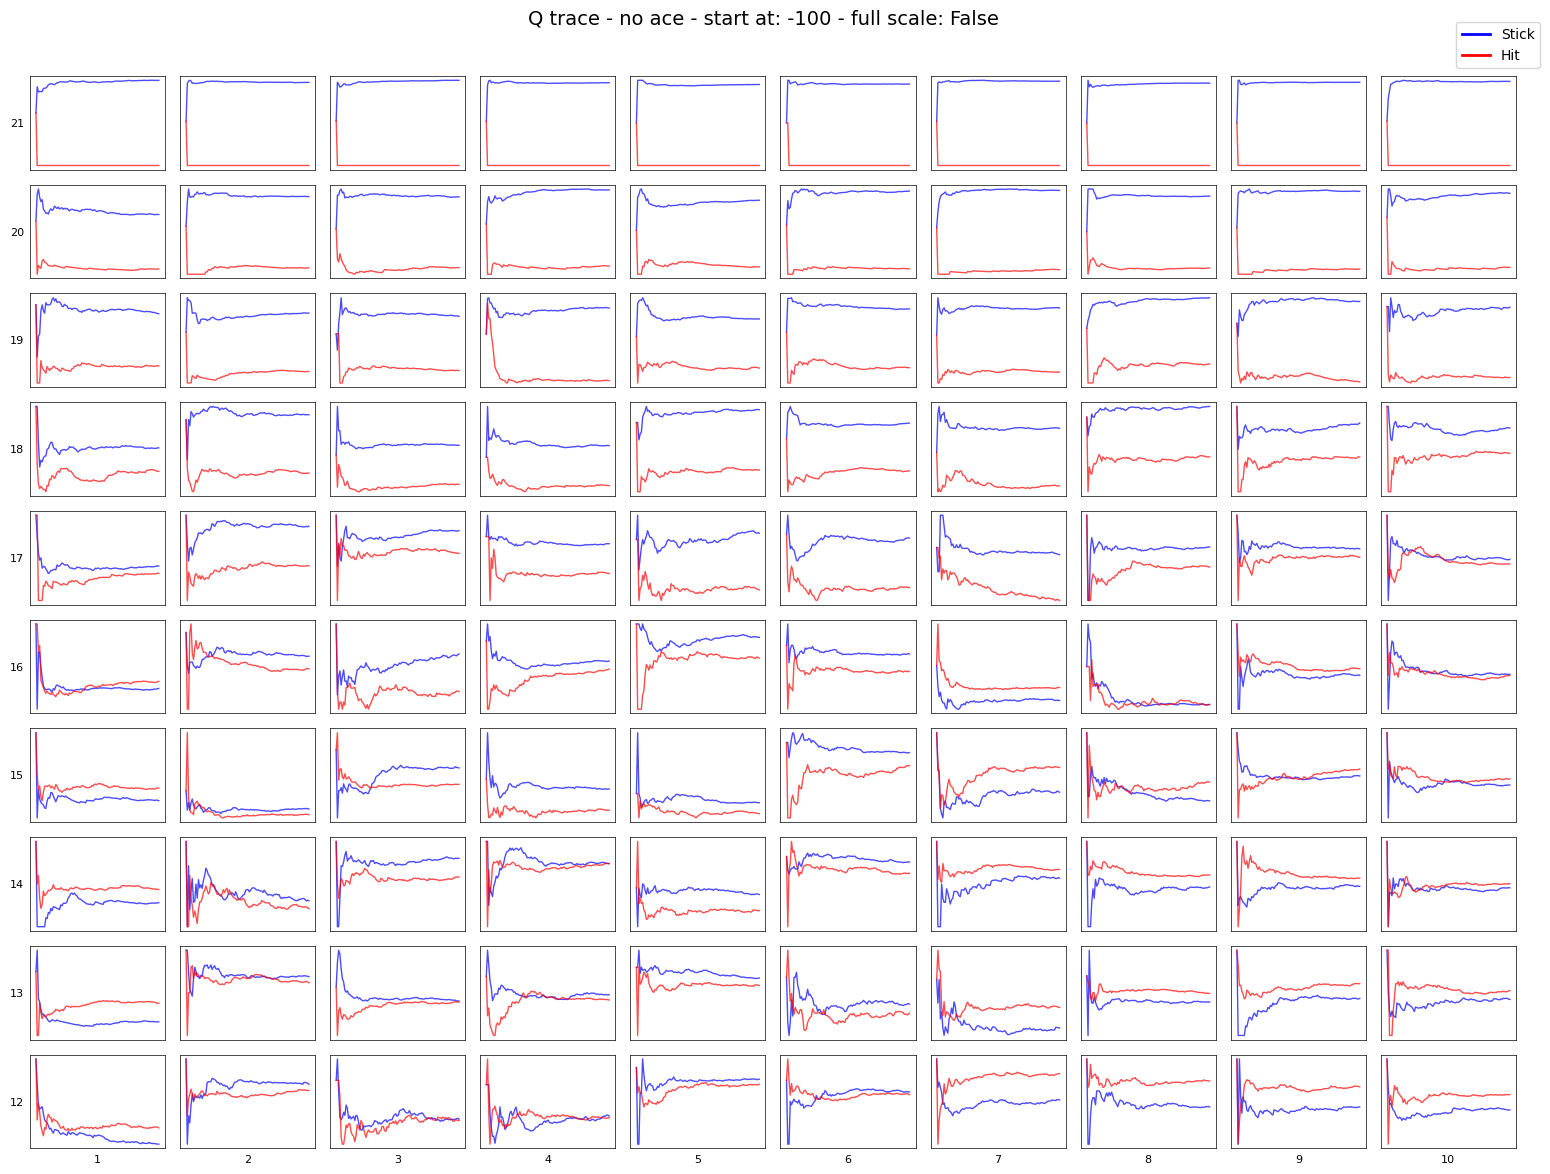


V(s) aproximado – usable_ace = True


dealer_card,1,2,3,4,5,6,7,8,9,10
player_sum,,,,,,,,,,
12,-0.273913,0.087719,0.160550,0.182879,0.108000,0.166667,0.181070,0.094421,-0.033058,-0.201521
13,-0.282353,0.023810,0.082988,0.110701,0.083969,0.112500,0.180723,0.003584,-0.134796,-0.252747
14,-0.353147,-0.003650,0.100346,-0.026936,0.097792,0.104027,0.101399,0.010239,-0.022436,-0.286853
15,-0.291391,0.005814,0.000000,0.000000,0.128125,0.125436,0.102473,-0.022876,-0.078370,-0.274760
16,-0.438547,-0.068966,-0.040881,-0.011594,0.123494,0.085366,0.072100,-0.114458,-0.187898,-0.253125
17,-0.424069,0.019231,-0.114370,0.024911,0.199482,0.047904,0.101449,-0.100264,-0.190476,-0.272455
18,-0.321212,0.154450,0.180556,0.130319,0.254237,0.304556,0.477690,0.134048,-0.134409,-0.196581
19,-0.137157,0.399072,0.399027,0.354667,0.467470,0.472081,0.622871,0.638554,0.267139,0.055138
20,0.098592,0.586854,0.606061,0.657718,0.627803,0.683486,0.783582,0.769231,0.769406,0.379391


V(s) aproximado – usable_ace = False


dealer_card,1,2,3,4,5,6,7,8,9,10
player_sum,,,,,,,,,,
12,-0.565619,-0.296703,-0.257541,-0.240924,-0.155738,-0.170068,-0.176015,-0.260784,-0.316981,-0.419048
13,-0.497196,-0.302128,-0.301344,-0.222462,-0.158287,-0.196653,-0.228240,-0.297619,-0.396552,-0.476190
14,-0.567568,-0.341772,-0.200000,-0.263844,-0.087649,-0.079681,-0.323268,-0.398026,-0.424704,-0.497345
15,-0.650327,-0.312621,-0.266667,-0.129326,-0.150376,-0.132710,-0.304124,-0.388170,-0.421978,-0.543771
16,-0.675944,-0.300847,-0.200723,-0.294939,-0.158491,-0.137037,-0.354167,-0.440964,-0.524390,-0.588946
17,-0.598347,-0.126195,-0.190000,-0.113095,0.044527,-0.039927,-0.065495,-0.371611,-0.391629,-0.516544
18,-0.429448,0.061508,0.199593,0.227872,0.191370,0.288270,0.366509,0.148693,-0.192082,-0.255924
19,-0.115445,0.368217,0.358650,0.416045,0.382979,0.461248,0.562777,0.559618,0.274247,-0.004902
20,0.122029,0.623377,0.633528,0.678309,0.679775,0.696721,0.793403,0.833049,0.775207,0.424590


CPU times: total: 48.8 s
Wall time: 49.1 s


In [ ]:
%%time
# EXEMPLO COMPLETO COM TRACE

# 1. Criar ambiente
env_ES = BlackjackES()

# 2. Setup trace
trace, callback = setup_trace_callback()

# 3. Treinar com trace
print("Treinando os episódios...")
Q, pi, resume = monte_carlo_ES_control_ext(
    env_ES,
    episodes=100000,
    gamma=1.0,
    callback=callback
)

print(f"\n✓ Treinamento concluído!")
print(f"✓ Snapshots capturados: {len(trace)}")
print(f"✓ Estados visitados: {len(set(s for (s, a) in Q.keys()))}")

# 4. Plotar resultados
plot_q_value_heatmap(Q, title_prefix='MC ES - ', state_values=True,
                     fmt='.2f', n_actions=env_ES.nb_actions)

plot_policy_heatmap(pi, title='Política ES', state_values=True)

# 5. Plotar trace (evolução dos Q-valores)
print("\nPlotando evolução dos Q-valores...")
plot_Q_trace(trace, has_ace=0, start_at=-100)  # últimos 100k episódios

# 6. Mostrar tabelas
V_approx = q_to_v_approx(Q, n_actions=env_ES.nb_actions)
df_true = value_dict_to_dataframe(V_approx, has_ace=True)
df_false = value_dict_to_dataframe(V_approx, has_ace=False)
print('\nV(s) aproximado – usable_ace = True'); display(df_true)
print('V(s) aproximado – usable_ace = False'); display(df_false)

In [ ]:
# ============================================================================
# FUNÇÃO DE AVALIAÇÃO - TAXA DE VITÓRIAS
# ============================================================================

def calcular_taxa_vitorias_es(env_ES, pi, n_jogos=100000, verbose=True):
    """
    Calcula a taxa de vitórias de uma política no Blackjack.
    Específico para MC ES Control (usa ambiente BlackjackES).

    Args:
        env_ES: instância de BlackjackES
        pi: política (dicionário {estado: ação})
        n_jogos: número de jogos para testar
        verbose: se True, mostra resultados detalhados

    Returns:
        dict com estatísticas (win_rate, wins, losses, draws)
    """
    vitorias = 0
    derrotas = 0
    empates = 0
    recompensas = []

    # Usar o ambiente interno do wrapper
    env = env_ES._env

    for jogo in range(n_jogos):
        # Reset do ambiente
        reset_ret = env.reset()
        state = reset_ret[0] if isinstance(reset_ret, tuple) else reset_ret
        done = False
        recompensa_episodio = 0

        # Jogar até terminar
        while not done:
            # Escolher ação pela política (padrão STICK=0 se estado desconhecido)
            action = pi.get(state, 0)

            # Executar ação
            step_ret = env.step(action)

            # Compatibilidade Gym/Gymnasium
            if len(step_ret) == 5:  # gymnasium
                state, reward, terminated, truncated, _ = step_ret
                done = terminated or truncated
            else:  # gym
                state, reward, done, _ = step_ret

            recompensa_episodio = reward

        # Contabilizar resultado
        recompensas.append(recompensa_episodio)
        if recompensa_episodio > 0:
            vitorias += 1
        elif recompensa_episodio < 0:
            derrotas += 1
        else:
            empates += 1

        # Progresso (a cada 10%)
        if verbose and (jogo + 1) % (n_jogos // 10) == 0:
            taxa_parcial = (vitorias / (jogo + 1)) * 100
            print(f"  Progresso: {jogo+1:>6}/{n_jogos} jogos | "
                  f"Win rate atual: {taxa_parcial:>5.2f}%")

    # Calcular estatísticas finais
    taxa_vitoria = (vitorias / n_jogos) * 100
    taxa_derrota = (derrotas / n_jogos) * 100
    taxa_empate = (empates / n_jogos) * 100
    recompensa_media = np.mean(recompensas)

    stats = {
        'wins': vitorias,
        'losses': derrotas,
        'draws': empates,
        'total_games': n_jogos,
        'win_rate': taxa_vitoria,
        'loss_rate': taxa_derrota,
        'draw_rate': taxa_empate,
        'avg_reward': recompensa_media
    }

    # Exibir resultados
    if verbose:
        print("\n" + "="*60)
        print(" RESULTADOS DA AVALIAÇÃO - TAXA DE VITÓRIAS")
        print("="*60)
        print(f"Total de jogos:  {n_jogos:>10,}")
        print("-"*60)
        print(f"Vitórias:        {vitorias:>10,}  ({taxa_vitoria:>6.2f}%)")
        print(f"Derrotas:        {derrotas:>10,}  ({taxa_derrota:>6.2f}%)")
        print(f"Empates:         {empates:>10,}  ({taxa_empate:>6.2f}%)")
        print("-"*60)
        print(f"Recompensa média: {recompensa_media:>9.4f}")
        print("="*60)

        # Interpretação
        print("\n📊 INTERPRETAÇÃO:")
        if taxa_vitoria >= 45:
            print("   🏆 EXCELENTE! Política muito forte.")
        elif taxa_vitoria >= 43:
            print("   ✅ ÓTIMO! Política próxima da ótima teórica.")
        elif taxa_vitoria >= 40:
            print("   ✓ BOM! Política competitiva.")
        elif taxa_vitoria >= 35:
            print("   ⚠ RAZOÁVEL. Considere mais episódios de treino.")
        else:
            print("   ❌ FRACO. Política precisa melhorar.")

        print("\n📈 REFERÊNCIAS:")
        print("   - Estratégia aleatória:     ~28-30%")
        print("   - Estratégia dealer (≥17):  ~42-44%")
        print("   - Política ótima teórica:   ~43-46%")
        print("="*60)

    return stats

In [ ]:
# Avaliar rapidamente
stats = calcular_taxa_vitorias_es(env_ES, pi, n_jogos=100000)

  Progresso:  10000/100000 jogos | Win rate atual: 40.02%
  Progresso:  20000/100000 jogos | Win rate atual: 40.32%
  Progresso:  30000/100000 jogos | Win rate atual: 40.22%
  Progresso:  40000/100000 jogos | Win rate atual: 40.03%
  Progresso:  50000/100000 jogos | Win rate atual: 40.06%
  Progresso:  60000/100000 jogos | Win rate atual: 40.23%
  Progresso:  70000/100000 jogos | Win rate atual: 40.15%
  Progresso:  80000/100000 jogos | Win rate atual: 40.20%
  Progresso:  90000/100000 jogos | Win rate atual: 40.09%
  Progresso: 100000/100000 jogos | Win rate atual: 40.07%

 RESULTADOS DA AVALIAÇÃO - TAXA DE VITÓRIAS
Total de jogos:     100,000
------------------------------------------------------------
Vitórias:            40,070  ( 40.07%)
Derrotas:            53,165  ( 53.16%)
Empates:              6,765  (  6.77%)
------------------------------------------------------------
Recompensa média:   -0.1310

📊 INTERPRETAÇÃO:
   ✓ BOM! Política competitiva.

📈 REFERÊNCIAS:
   - Estratégi